# XGBoost - Open-world Binary Scenario (Extra Features)

**Feature 소스**: extra_credit/features/extra_mon_features.pkl, extra_unmon_features.pkl
- **시나리오**: Monitored vs Unmonitored 이진 분류
- **Extra Features 사용**: 모든 17개 extra features 사용


## 1. 라이브러리 및 데이터 로드


In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [ ]:
# Load extra features (numpy 2.x 호환 패치)
print("Extra Monitored 데이터 로드 중...")

# numpy 2.x 환경에서 예전 버전으로 저장된 pickle 호환을 위한 패치
import sys
import numpy.core.numeric as _numeric
sys.modules.setdefault('numpy._core.numeric', _numeric)

# Monitored: extra features
mon_features = pd.read_pickle('../../features/extra_mon_features.pkl')
print(f"Monitored 데이터 형태: {mon_features.shape}")

# Unmonitored: extra features
print("\nExtra Unmonitored 데이터 로드 중...")
unmon_features = pd.read_pickle('../../features/extra_unmon_features.pkl')
print(f"Extra Unmonitored 데이터 형태: {unmon_features.shape}")
print("데이터 로드 완료!")


Extra Monitored 데이터 로드 중...
Monitored 데이터 형태: (19000, 18)

Extra Unmonitored 데이터 로드 중...
Extra Unmonitored 데이터 형태: (19000, 18)
데이터 로드 완료!


## 2. Feature 선택


In [ ]:
# 모든 extra features 사용 (label 제외)
feature_cols = [col for col in mon_features.columns if col != 'label']
selected_features = feature_cols

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")


선택된 Feature 수: 17

Feature 목록:
 1. total_transmission_time
 2. std_inter_packet_time
 3. avg_outgoing_burst_size
 4. avg_incoming_burst_size
 5. num_outgoing_packets
 6. incoming_packet_ratio
 7. outgoing_packet_ratio
 8. cumul_packets_10pct
 9. cumul_packets_30pct
10. outgoing_order_skew
11. incoming_order_skew
12. cumul_max
13. bigram_OO
14. num_incoming_first_30
15. outgoing_first_30
16. avg_incoming_order_first_30
17. avg_outgoing_order_first_30


## 3. 데이터 준비 (Binary Classification)


In [ ]:
# Open-world binary: monitored vs unmonitored 이진 분류
# Combine mon_features and unmon_features
features_df = pd.concat([mon_features, unmon_features], ignore_index=True)

# Create binary labels: 1 for monitored, 0 for unmonitored
y = (features_df['label'] >= 0).astype(int)  # Monitored (0-94) -> 1, Unmonitored (-1) -> 0

X = features_df[selected_features]

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"Monitored 샘플: {sum(y == 1)} (클래스 1)")
print(f"Unmonitored 샘플: {sum(y == 0)} (클래스 0)")
print(f"클래스 비율: {sum(y == 1)/sum(y == 0):.1f}:1")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"  - Monitored: {sum(y_train == 1)} 샘플")
print(f"  - Unmonitored: {sum(y_train == 0)} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")
print(f"  - Monitored: {sum(y_test == 1)} 샘플")
print(f"  - Unmonitored: {sum(y_test == 0)} 샘플")


전체 샘플 수: 38000
Feature 수: 17
Monitored 샘플: 19000 (클래스 1)
Unmonitored 샘플: 19000 (클래스 0)
클래스 비율: 1.0:1

훈련 데이터: 30400 샘플
  - Monitored: 15200 샘플
  - Unmonitored: 15200 샘플
테스트 데이터: 7600 샘플
  - Monitored: 3800 샘플
  - Unmonitored: 3800 샘플


## 4. XGBoost 모델 훈련 및 평가


In [ ]:
# 최적 하이퍼파라미터
best_params = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

print("최적 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# XGBoost 모델 훈련
print("\nXGBoost 모델 훈련 중...")
xgb_clf = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_binary = f1_score(y_test, y_pred, average='binary')

print("\n" + "="*60)
print("OPEN-WORLD BINARY XGBOOST 결과 (Extra Features)")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Binary): {f1_binary:.4f}")
print("="*60)

# 상세 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, 
                          target_names=['Unmonitored', 'Monitored'],
                          digits=4))


최적 하이퍼파라미터:
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 0.1
  reg_lambda: 1.0
  objective: binary:logistic
  eval_metric: logloss

XGBoost 모델 훈련 중...
모델 훈련 완료!

OPEN-WORLD BINARY XGBOOST 결과 (Extra Features)
정확도 (Accuracy): 0.6689 (66.89%)
F1-Score (Binary): 0.6675

분류 리포트:
              precision    recall  f1-score   support

 Unmonitored     0.6674    0.6734    0.6704      3800
   Monitored     0.6705    0.6645    0.6675      3800

    accuracy                         0.6689      7600
   macro avg     0.6690    0.6689    0.6689      7600
weighted avg     0.6690    0.6689    0.6689      7600



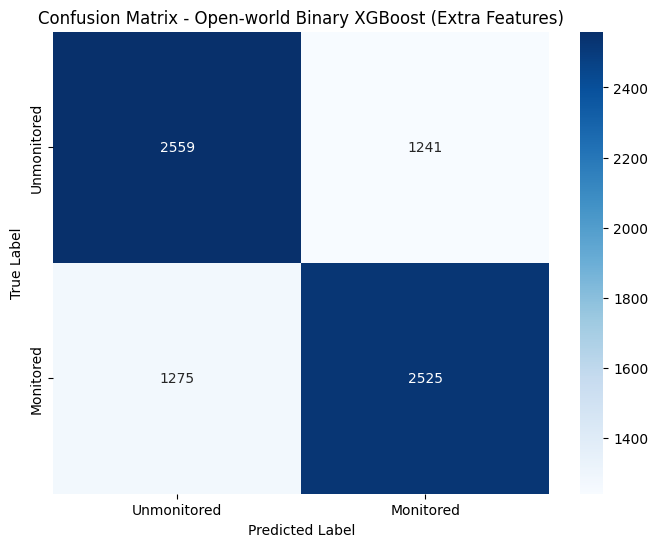


Feature 중요도:
                    feature  importance
      num_incoming_first_30    0.125183
    total_transmission_time    0.091268
        cumul_packets_30pct    0.086444
          outgoing_first_30    0.074863
avg_incoming_order_first_30    0.074484
                  cumul_max    0.071931
        cumul_packets_10pct    0.059482
      outgoing_packet_ratio    0.054708
      std_inter_packet_time    0.053976
avg_outgoing_order_first_30    0.045324
       num_outgoing_packets    0.040849
                  bigram_OO    0.040417
      incoming_packet_ratio    0.039903
    avg_incoming_burst_size    0.039202
    avg_outgoing_burst_size    0.035704
        incoming_order_skew    0.033668
        outgoing_order_skew    0.032595


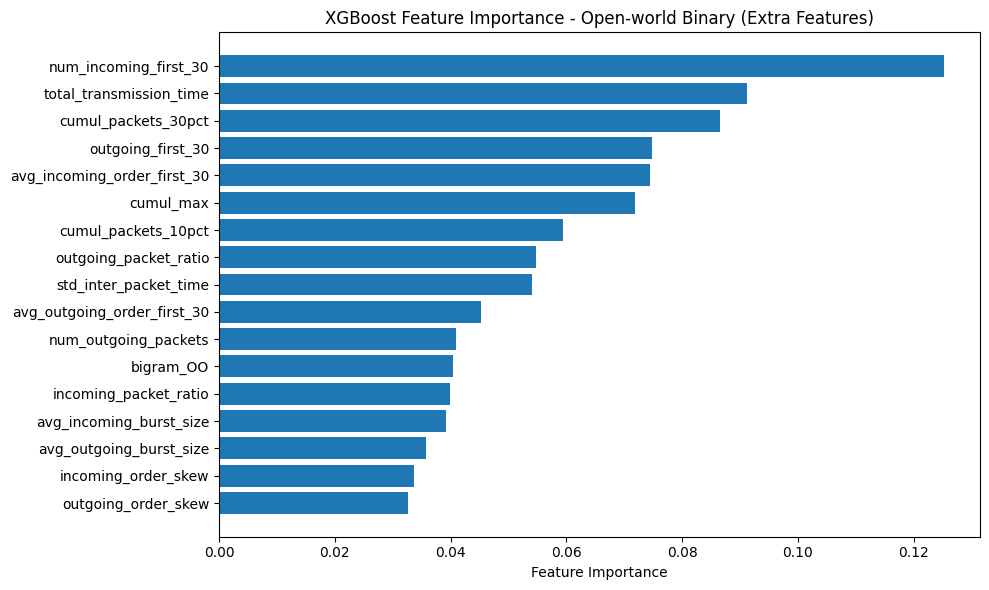

In [ ]:
# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unmonitored', 'Monitored'],
            yticklabels=['Unmonitored', 'Monitored'])
plt.title('Confusion Matrix - Open-world Binary XGBoost (Extra Features)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature 중요도 분석
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature 중요도:")
print(feature_importance.to_string(index=False))

# Feature 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance - Open-world Binary (Extra Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
